Linear regression with square-root loss
---------

### Linear regression model

Linear regression model assumes a linear relationship between a response variable $Y_i$ and $p$ predictor variables $X_i$, it's a popular statistical model used for predicting. Given an i.i.d data with sample size $n$ and i.i.d zero-mean random noises $\epsilon=(\epsilon_1,\ldots,\epsilon_n)^{\prime}$, the linear regression model can be represented as:
$$Y=X\beta + \epsilon,$$
where $Y=(Y_1,\ldots,Y_n)^{\prime}\in \mathbb{R}^n$ and $X=(X_1,\ldots, X_n)^{\prime} \in \mathbb{R}^{n\times p}$. 

And the following piece of code is used to generate data for a linear regression model, the random noise $\epsilon_i\sim t_4/\sqrt{2}$, so that $Var(\epsilon_i)=1$.

In [1]:
# generate linear regression data
import numpy as np
import numpy.random as rd

def make_linear_reg(n, p, s, signal=1, rho=0.5,seed=0):
    coef = np.append(signal*np.ones(s),np.zeros(p-s))
    mu = np.zeros(p)
    Sigma = np.power(rho, np.abs(np.linspace(1, p, p) - np.linspace(1, p, p).reshape(p, 1)))
    X = rd.multivariate_normal(mu, Sigma, size=(n,))    # variables
    Y = np.matmul(X,coef) + rd.standard_t(4, size=(n,))/10
    return X,Y,coef

### Square-root lasso


The dimension $p$ may be much larger than the sample size $n$, the assumption of sparsity of regression coefficients is common. And various regularized methods have been used in variable selection for linear regression models. However, the theoretical properties of regression parameter estimation depend on the normality or sub-Gaussianity of the random noises in most studies. 

[[1]](#refer-1) proposes a pivotal method for estimating high-dimensional sparse linear regression, called square-root (SQRT) lasso, which does not rely on the knowledge of the standard deviation of noise and the normality or sub-Gaussianity of noises. The optimization problem is 
$$\underset{\beta\in\mathbb{R}^n}{\min} \{Q(\beta)\}^{1/2} + \frac{\lambda}{n}\|\beta\|_1,$$
where $Q(\beta)=n^{-1}\sum_{i=1}^{n}(Y_i-X_i^{\prime}\beta)^2$ is loss function and $\lambda$ for some constant $c>1$ is penalty parameter. The optimal regularization parameter is 
$$\lambda_{\text{SQRT}}\asymp \sqrt{\frac{\log p}{n}},$$
the penalty level is independent of $\sigma$. It's notable that the optimization problem is non-convex, which means the s computation is complex.

### Subset selection for square-root loss 

In the frame of best subset selection, considering the following optimization problemc
$$\underset{\beta\in\mathbb{R}^n}{\min} \{Q(\beta)\}^{1/2}, \text{ s.t. } \|\beta\|_0\leq s.$$
Here is a Python code for solving the sparse optimization problem. The number of variables $p=200$, the number of non-zero parameters $s=5$, and all non-zero regression coefficients are set to 0.2. Then we set the sample size n ranging from 50 to 300 with an increment of 50, each setting is repeated 50 times. We use PDR, FDR and MCC to measure the quality of variable selection, and use log relative error to measure the goodness of parameter estimation.

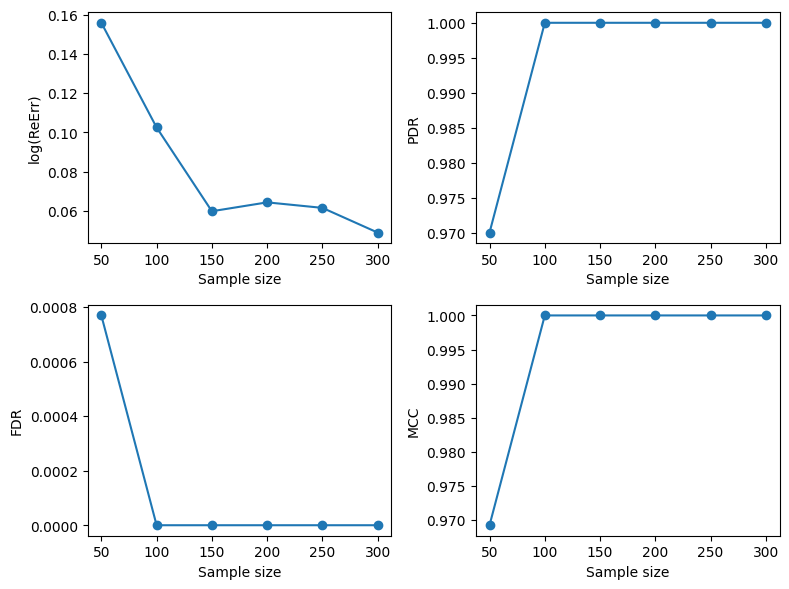

In [24]:
from skscope import ScopeSolver
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import jax.numpy as jnp

p,s=200, 5
N = np.linspace(50, 300, 6 ,dtype=int)   # differnt sample size
repeat_time = 20                          # repeat time

met = np.zeros((len(N), repeat_time, 4)) 
for ni,n_size in enumerate(N): 
    for k in range(repeat_time):
        X,Y,coef = make_linear_reg(n=n_size,p=p,s=s,signal=0.2, rho=0.5,seed=k)    # simulate data
        real_ind = (coef!=0)
        def square_root_linear_objective(params):
            return jnp.square(jnp.sum(jnp.square(Y - jnp.matmul(X, params)))/n_size)
        solver = ScopeSolver(p, s)
        solver.solve(square_root_linear_objective, jit=True)
        coef_est = solver.get_result()["params"]
        est_ind = (coef_est!=0)
        met[ni,k,0] = np.linalg.norm(coef_est - coef) / np.linalg.norm(coef)   # error
        met[ni,k,1] = sum(real_ind & est_ind) / sum(real_ind)                  # pdr
        met[ni,k,2] = sum(~real_ind & est_ind) / sum(~real_ind)                # fdr
        met[ni,k,3] = matthews_corrcoef(real_ind , est_ind)                    # mcc


# results matrix  
res = np.zeros((len(N), 8))    
for ni, n in enumerate(N):           
    temp1 = np.nanmean(met[ni],axis=0) # mean
    temp2 = np.nanstd(met[ni],axis=0)  # st
    res[ni, 0:8] = np.hstack((temp1, temp2)) 
label = ['log(ReErr)', 'PDR', 'FDR', 'MCC']


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

for i, ax in enumerate(axs.flatten()):
    ax.plot(N, res[:, i],marker='o')
    ax.set_ylabel(label[i])
    ax.set_xlabel('Sample size')

plt.tight_layout()
plt.show()

As the sample size n increases, the subset selection accuracy becomes higher and higher, reaching selection consistency at about a sample size of 100.

### Reference

<div id="refer-1"></div>

- [1] Belloni, A., Chernozhukov, V., & Wang, L. (2011). Square-root lasso: pivotal recovery of sparse signals via conic programming. Biometrika, 98(4), 791-806.